In [1]:
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "lines.linewidth": 0.5,
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
    }
)

In [2]:
def gq_h(strains, tmax, Gmax, Dmin, theta1, theta2, theta3, theta4, theta5, p1, p2, p3):
    yr = tmax / Gmax

    phi_t_func = lambda strain: theta1 + theta2 * theta4 * (strain / yr) ** theta5 / (
        theta3**theta5 + theta4 * (strain / yr) ** theta5
    )
    tau_func = lambda strain, phi_t: (tmax * 2 * strain / yr) / (
        1 + strain / yr + ((1 + strain / yr) ** 2 - 4 * phi_t * strain / yr) ** 0.5
    )

    phi_t_bb = phi_t_func(strains)
    tau_bb = tau_func(strains, phi_t_bb)

    g_gmax = tau_bb / strains / Gmax

    damp = []

    y_hyst = []
    tau_hyst = []

    for i, y in enumerate(strains):
        phi_t = phi_t_func(y)
        tau_y = tau_func(y, phi_t)
        g_y = tau_y / y
        f_ymax = p1 - p2 * (1 - g_y / Gmax) ** p3

        yc = np.linspace(-y, y, 300)

        phi_tc_p = phi_t_func((yc + y) / 2)

        fbb_p = tau_func((yc + y) / 2, phi_tc_p)
        tc_p = f_ymax * (2 * fbb_p - g_y * (yc + y)) + g_y * (yc + y) - tau_y

        y_plot = np.concatenate((yc, yc[::-1]))
        t_plot = np.concatenate((tc_p, -tc_p))

        E_plastic = Polygon(zip(y_plot, t_plot))
        E_elastic = tau_y * y / 2

        damping = E_plastic.area / 4 / np.pi / E_elastic
        damp.append(damping + Dmin / 100)

        y_hyst.append(y_plot)
        tau_hyst.append(t_plot)

    return strains, tau_bb, g_gmax, np.array(damp), np.array(y_hyst), np.array(tau_hyst)

In [3]:
strains = (
    np.array(
        [
            0.0001,
            0.0003,
            0.0007,
            0.001,
            0.003,
            0.007,
            0.01,
            0.03,
            0.07,
            0.1,
            0.3,
            0.7,
            1,
            3,
            7,
            10,
        ]
    )
    / 100
)
tmax = 75  # kPa
Gmax = 20 / 9.81 * 270 * 270  # kPa

Dmin = 0.784064  # %
theta1 = -1.11
theta2 = 0.78
theta3 = 1
theta4 = 1
theta5 = 0.05
P1 = 0.55
P2 = 0.25
P3 = 16

strains, tau_bb, g_gmax, damp, y_hyst, tau_hyst = gq_h(
    strains, tmax, Gmax, Dmin, theta1, theta2, theta3, theta4, theta5, P1, P2, P3
)

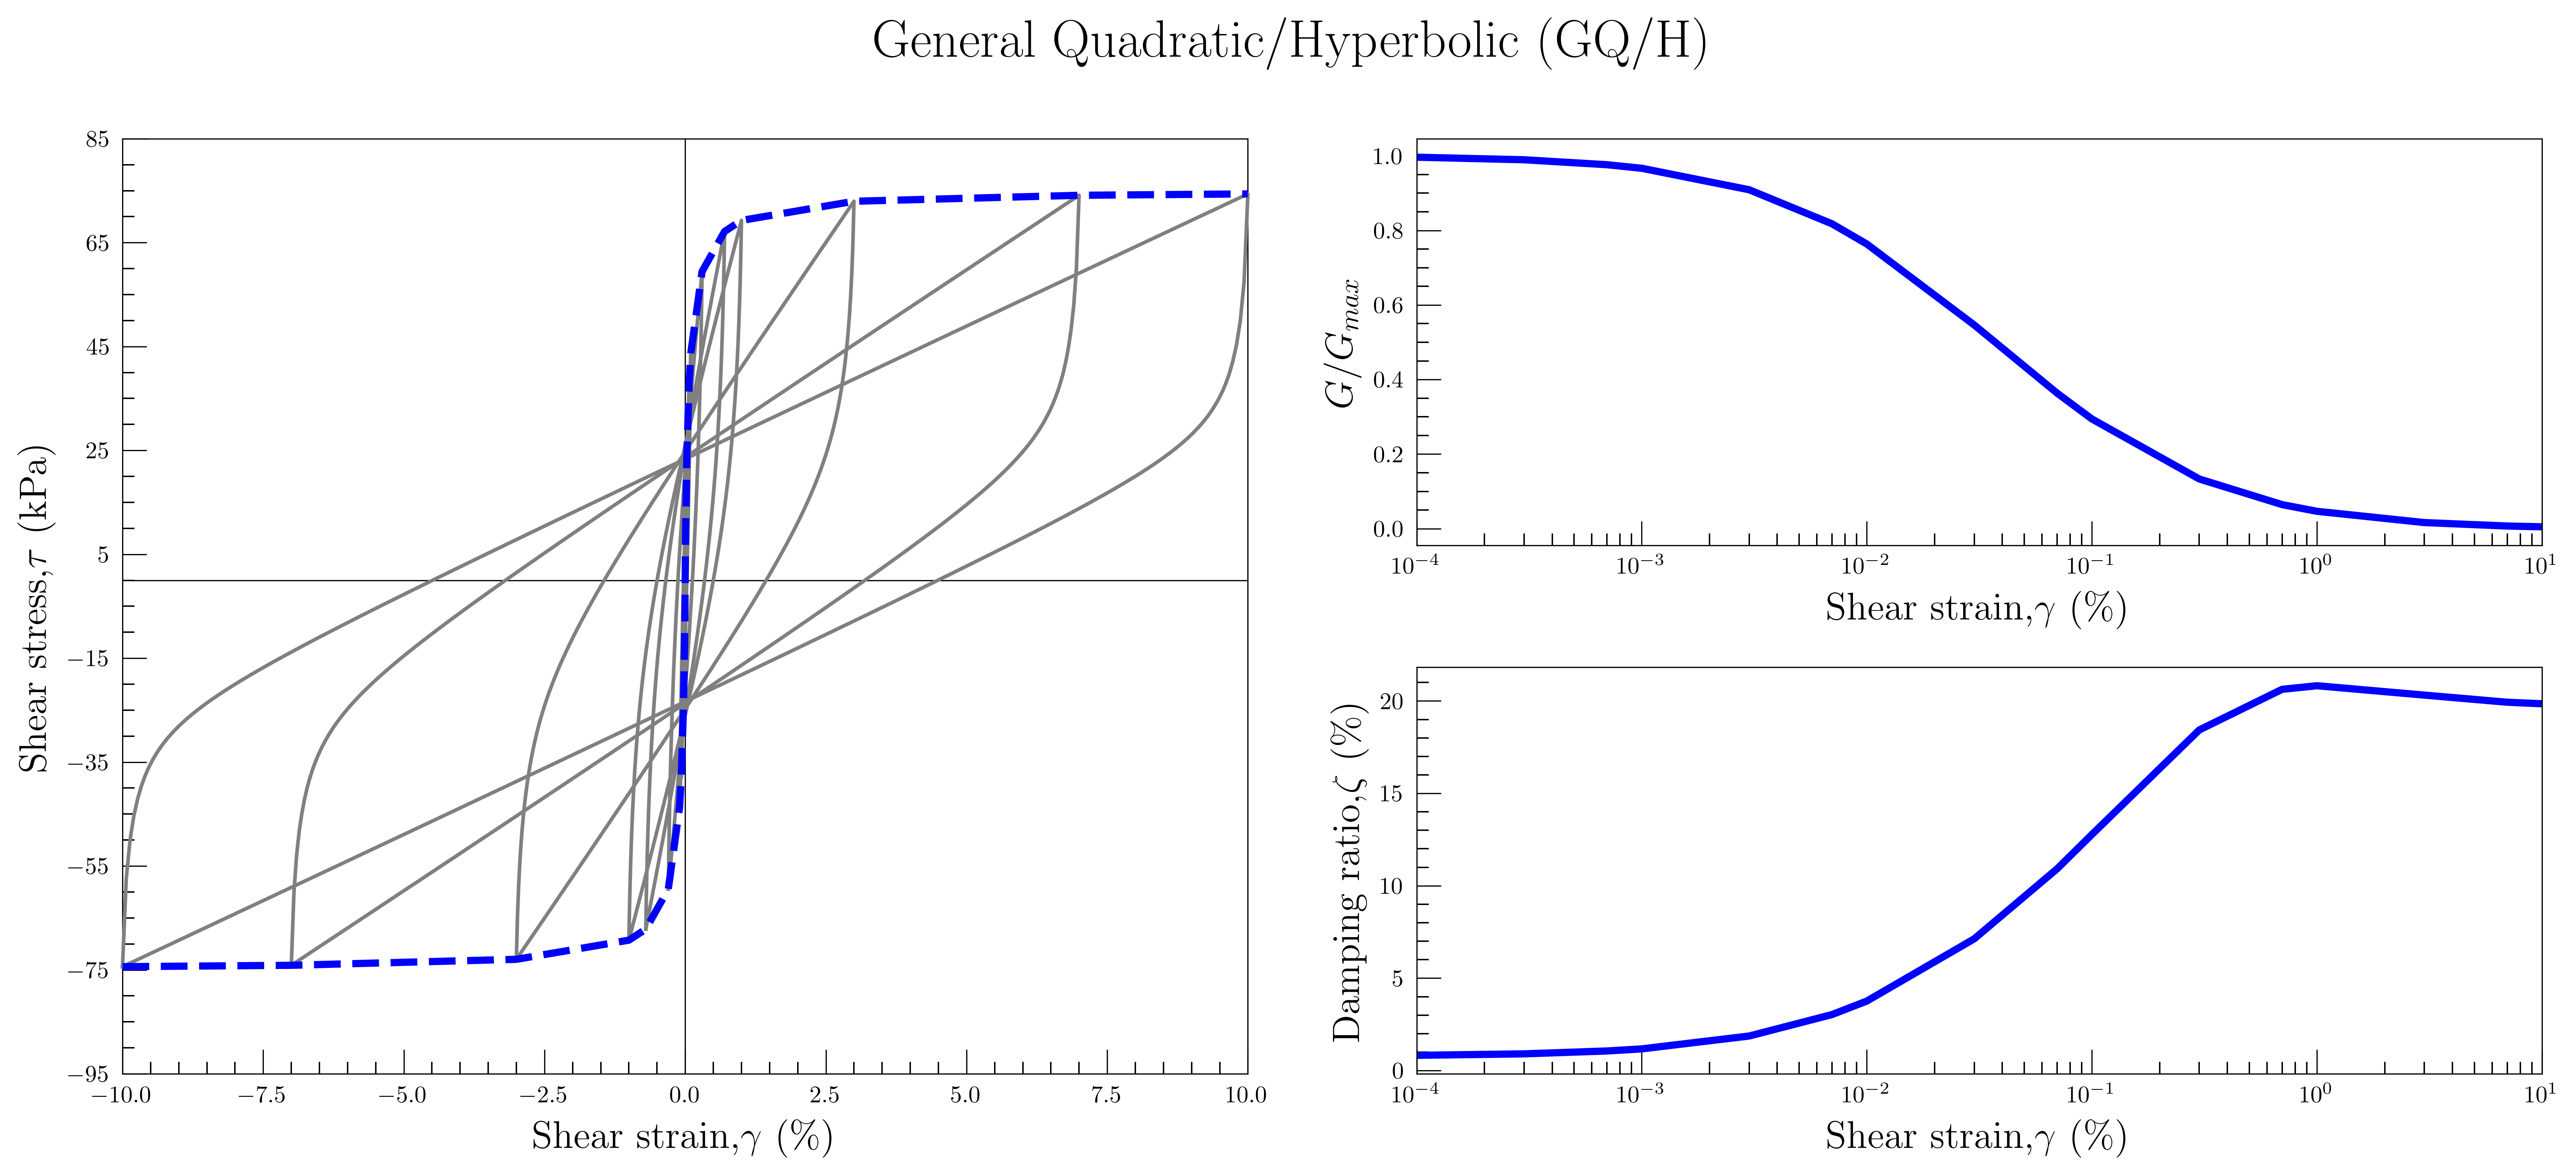

In [4]:
fig = plt.figure(figsize=(18, 7), dpi=480)
grid_spec = fig.add_gridspec(ncols=2, nrows=2, wspace=0.15, hspace=0.3)
ax = fig.add_subplot(grid_spec[:, 0])
ax.axvline(0, c="k")
ax.axhline(0, c="k")

for i in range(len(y_hyst)):
    ax.plot(
        y_hyst[i] * 100, tau_hyst[i], c="gray", alpha=1, lw=1.5, clip_on=False, zorder=8
    )

ax.plot(
    np.concatenate((-strains[::-1], strains)) * 100,
    np.concatenate((-tau_bb[::-1], tau_bb)),
    c="blue",
    lw=3,
    ls="--",
    zorder=9,
)

ax.set_xlabel(r"Shear strain,$\gamma$ ($\%$)", fontsize=16, labelpad=5)
ax.set_ylabel(r"Shear stress,$\tau$ (kPa)", fontsize=16, labelpad=5)
fig.suptitle(r"General Quadratic/Hyperbolic (GQ/H)", fontsize=22)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ticks_y = ax.get_yticks()
s_y = np.diff(ticks_y)[0]
ax.set_yticks(np.arange(-tmax - s_y, tmax + s_y + 0.1, s_y))

ax1 = fig.add_subplot(grid_spec[0, 1])
ax1.plot(strains * 100, g_gmax, c="blue", lw=3)
ax1.set_xscale("log")
ax1.set_xlabel(r"Shear strain,$\gamma$ ($\%$)", fontsize=16, labelpad=5)
ax1.set_ylabel(r"$G/G_{max}$", fontsize=16, labelpad=5)

ax2 = fig.add_subplot(grid_spec[1, 1])
ax2.plot(strains * 100, np.array(damp) * 100, c="blue", lw=3)
ax2.set_xscale("log")
ax2.set_xlabel(r"Shear strain,$\gamma$ ($\%$)", fontsize=16, labelpad=5)
ax2.set_ylabel(r"Damping ratio,$\zeta$ ($\%$)", fontsize=16, labelpad=5)

for axi in [ax, ax1, ax2]:
    axi.yaxis.set_minor_locator(AutoMinorLocator())
    axi.tick_params(axis="x", direction="in", length=10, colors="k", pad=5)
    axi.tick_params(axis="y", direction="in", length=10, colors="k", pad=5)
    axi.tick_params(axis="x", which="minor", direction="in", length=5, colors="k")
    axi.tick_params(axis="y", which="minor", direction="in", length=5, colors="k")
    axi.margins(x=0)

plt.show()